In [1]:
import os

import torch

import mne

import multiprocessing

from scipy.io import wavfile
import matplotlib.pyplot as plt

### Audio

In [2]:
def list_files(rootdir):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)
        if os.path.isdir(curr_object): 
            files += list_files(curr_object)
        elif ".wav" in curr_object:
            files.append(curr_object)

    return files

# Replace 'directory_path' with the path of the directory you want to search
# directory_path = '/home/oturgut/data/AudioSet/archive/train_wav'
directory_path = '/home/oturgut/data/AudioSet/archive/train_wav/'
files = list_files(directory_path)

In [3]:
len(files)

19644

In [4]:
files[0]

'/home/oturgut/data/AudioSet/archive/train_wav/RHki6zf7fLk.wav'

In [5]:
tensors = []
curr_file = ""

for file in files:
    curr_file = file
    samplerate, data = wavfile.read(file)

    tensor = torch.from_numpy(data)
    if tensor.dim() == 1:
        tensor = tensor[..., None]

    tensor = tensor.transpose(1, 0)

    if tensor.shape[-1] == 0:
        continue
    
    tensor = tensor.to(dtype=torch.float32)
    tensor_normalised = ( tensor - tensor.mean(dim=-1, keepdim=True) ) / ( tensor.std(dim=-1, keepdim=True) + 1e-9 )

    tensors.append(tensor_normalised)

In [14]:
len(tensors)

19642

In [15]:
tensors[0].shape

torch.Size([2, 441028])

In [8]:
tensors[0].max(), tensors[0].min(), tensors[0].mean(), tensors[0].std()

(tensor(53.7459), tensor(-52.0407), tensor(1.1071e-09), tensor(1.0000))

In [54]:
len(files)

19644

In [ ]:
def process_file(file):
    try:
        samplerate, data = wavfile.read(file)

        tensor = torch.from_numpy(data)
        if tensor.dim() == 1:
            tensor = tensor[..., None]

        tensor = tensor.transpose(1, 0)

        if tensor.shape[-1] == 0:
            return None
        
        tensor = tensor.to(dtype=torch.float32)
        tensor_normalised = (tensor - tensor.mean(dim=-1, keepdim=True)) / (tensor.std(dim=-1, keepdim=True) + 1e-9)

        return tensor_normalised
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        return None

if __name__ == "__main__":
    # Number of processes to use
    num_processes = 32

    with multiprocessing.Pool(processes=num_processes) as pool:
        tensors_ = pool.map(process_file, files)

    # Remove any None values (failed files)
    # tensors_ = [tensor for tensor in tensors_ if tensor is not None]

    print(f"Processed {len(tensors_)} files.")

In [16]:
univariate = [tensor.shape for tensor in tensors if tensor.shape[0] == 1]
multivariate = [tensor.shape for tensor in tensors if tensor.shape[0] == 2]

In [17]:
len(univariate), len(multivariate)

(3491, 16123)

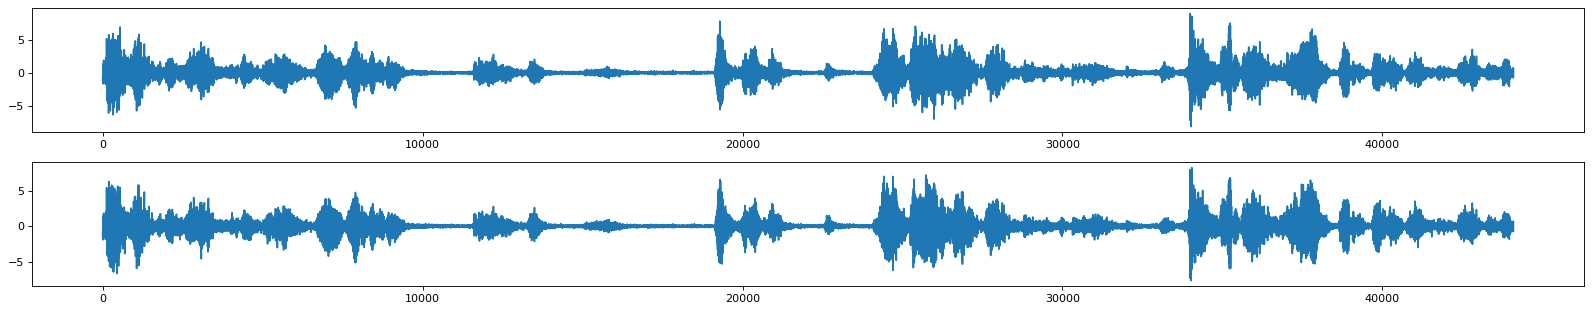

In [10]:
subject = 100
data_audio = tensors[subject]

step = 10
plt.figure(figsize=(20, 4), dpi=80)

plt.subplot(2,1,1)
plt.plot(data_audio[0, ::step])

plt.subplot(2,1,2)
plt.plot(data_audio[1, ::step])

plt.tight_layout()
plt.show()

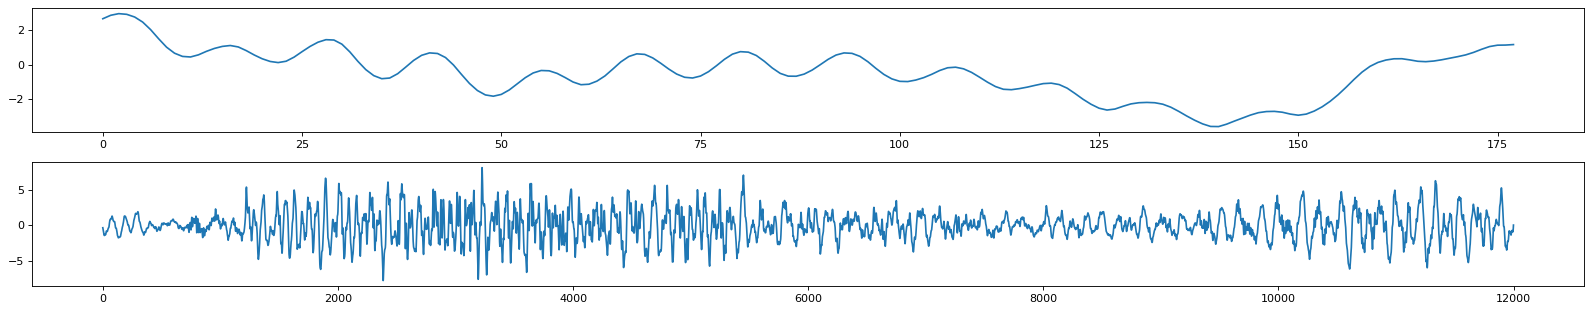

In [11]:
step = 1
plt.figure(figsize=(20, 4), dpi=80)

plt.subplot(2,1,1)
plt.plot(data_audio[0, 10000:10178:step])

plt.subplot(2,1,2)
plt.plot(data_audio[0, :12000:step])

plt.tight_layout()
plt.show()

In [31]:
mono_audio = [("audio_mono", tensor) for tensor in tensors if tensor.shape[0] == 1]
len(mono_audio)

3491

In [32]:
stereo_audio = [("audio_stereo", tensor) for tensor in tensors if tensor.shape[0] == 2]
len(stereo_audio)

16123

In [33]:
audioset = mono_audio + stereo_audio

In [34]:
audioset[12250]

('audio_stereo',
 tensor([[-1.2139, -1.2646, -1.2155,  ...,  1.0265,  1.1844,  1.2730],
         [-0.3056, -0.2012, -0.0285,  ...,  1.3067,  1.3564,  1.3081]]))

In [38]:
audioset_float16 = [(data[0], data[1].to(dtype=torch.float16)) for data in audioset]

In [42]:
# torch.save(audioset_float16, "/home/oturgut/data/processed/signalnet/audioset_20k_float16.pt")
# torch.save(audioset, "/home/oturgut/data/processed/signalnet/audioset_20k.pt")

### Sleep EEG

In [43]:
sleep_eeg = torch.load("/home/oturgut/data/signalnet/datasets/classification/SleepEEG/train.pt")

In [44]:
len(sleep_eeg["samples"]), sleep_eeg["samples"].shape

(371055, torch.Size([371055, 1, 178]))

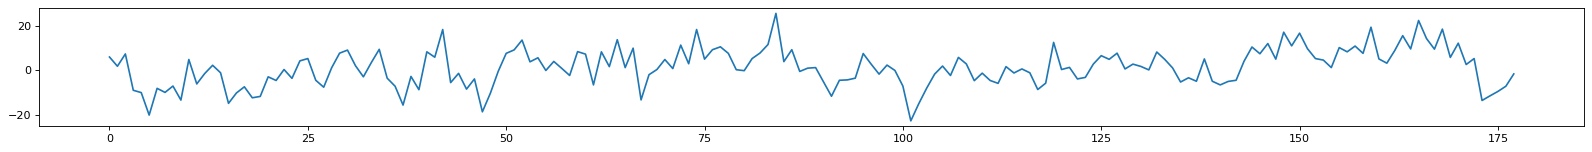

In [45]:
step = 1
plt.figure(figsize=(20, 2), dpi=80)

plt.subplot(1, 1, 1)
plt.plot(sleep_eeg["samples"][0, 0, ::step])

plt.tight_layout()
plt.show()

In [46]:
data_sleep = (sleep_eeg["samples"] - sleep_eeg["samples"].mean(dim=-1, keepdim=True)) / (sleep_eeg["samples"].std(dim=-1, keepdim=True) + 1e-9)

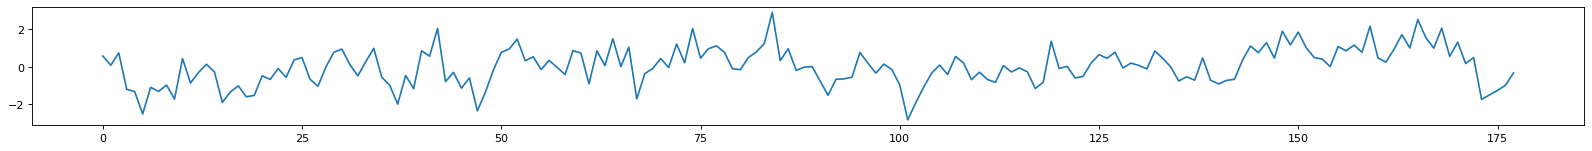

In [47]:
step = 1
plt.figure(figsize=(20, 2), dpi=80)

plt.subplot(1, 1, 1)
plt.plot(data_sleep[0, 0, ::step])

plt.tight_layout()
plt.show()

In [55]:
sleepeeg = [("eeg_sleep", data) for data in data_sleep]

In [56]:
sleepeeg[0][1].shape

torch.Size([1, 178])

In [57]:
# torch.save(sleepeeg, "/home/oturgut/data/processed/signalnet/sleepeeg_train.pt")

### TDBrain

In [2]:
def list_files(rootdir):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)
        if os.path.isdir(curr_object): 
            files += list_files(curr_object)
        elif ".vhdr" in curr_object:
            files.append(curr_object)

    return files

# Replace 'directory_path' with the path of the directory you want to search
directory_path = '/home/oturgut/data/TDBrain/'
files = list_files(directory_path)

In [3]:
len(files)

2692

In [4]:
data_tdb = []

for file in sorted(files):
    data_raw = mne.io.read_raw_brainvision(file, verbose=False)

    tensor = torch.from_numpy(data_raw.load_data(verbose=False)._data).to(dtype=torch.float32)
    tensor_normalised = ( tensor - tensor.mean(dim=-1, keepdim=True) ) / ( tensor.std(dim=-1, keepdim=True) + 1e-9 )

    data_tdb.append(tensor_normalised) 

In [109]:
len(data_tdb), data_tdb[0].shape, data_tdb[0].dtype

(2692, torch.Size([33, 60003]), torch.float32)

In [103]:
data_tdb[0].min(), data_tdb[0].max(), data_tdb[0].mean(), data_tdb[0].std()

(tensor(-6.7275), tensor(4.0723), tensor(-2.8585e-06), tensor(1.0000))

In [88]:
tdbrain = [("eeg_rest", data) for data in data_tdb]

In [89]:
len(tdbrain)

2692

In [95]:
tdbrain[0][1].shape

torch.Size([33, 60003])

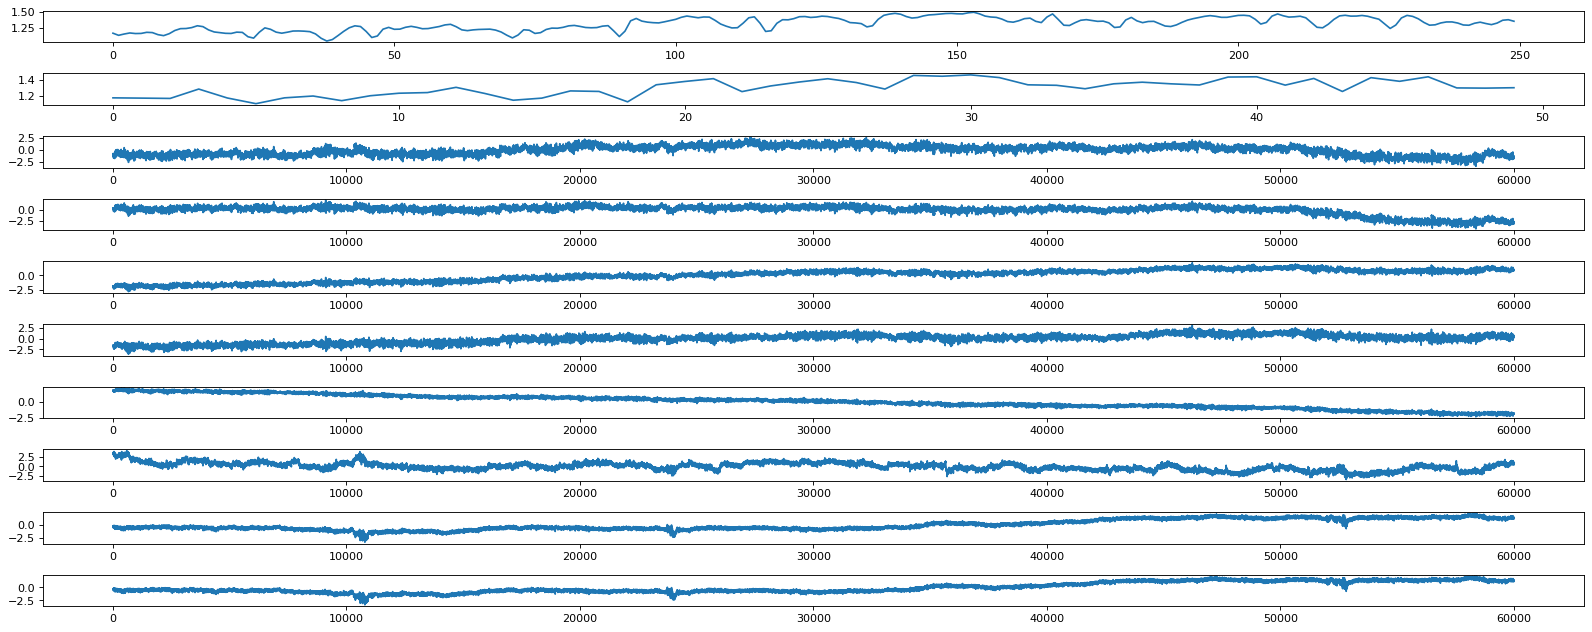

In [108]:
subject = 0

data = data_tdb[0][None, ...]

step = 1
plt.figure(figsize=(20, 8), dpi=80)

plt.subplot(10,1,1)
plt.plot(data[subject, 0, :250:step])

plt.subplot(10,1,2)
plt.plot(data[subject, 0, :250:step*5])

plt.subplot(10,1,3)
plt.plot(data[subject, 8, ::step])

plt.subplot(10,1,4)
plt.plot(data[subject, 12, ::step])

plt.subplot(10,1,5)
plt.plot(data[subject, 16, ::step])

plt.subplot(10,1,6)
plt.plot(data[subject, 20, ::step])

plt.subplot(10,1,7)
plt.plot(data[subject, 24, ::step])

plt.subplot(10,1,8)
plt.plot(data[subject, 28, ::step])

plt.subplot(10,1,9)
plt.plot(data[subject, 32, ::step])

plt.subplot(10,1,10)
plt.plot(data[subject, 32, ::step])

plt.tight_layout()
plt.show()

In [5]:
def plot_psd(data, subject=0, channel=0, fs=100):
    x_t = data[subject][channel]

    N = x_t.shape[-1]
    t = torch.arange(0, N) * 1/fs

    plt.figure(figsize=(15, 4))

    plt.subplot(211)
    plt.plot(t, x_t)
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')

    plt.subplot(212)
    plt.psd(x_t, 1024, fs)
    plt.xlabel('f [Hz]')

    plt.tight_layout()
    plt.show()

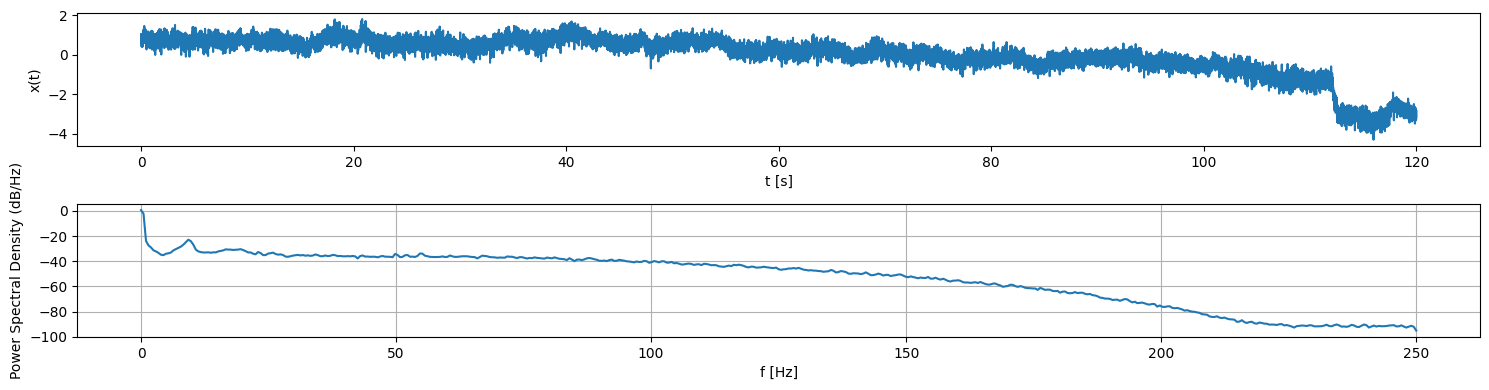

In [7]:
subject = 0
channel = 5
fs = 500
plot_psd(data_tdb[0][None, ...], subject=subject, channel=channel, fs=fs)

In [ ]:
# torch.save(tdbrain, "/home/oturgut/data/processed/signalnet/tdbrain.pt")

### Visualisation

In [2]:
ecg = torch.load("/home/oturgut/data/processed/mimic-ecg-text/ecgs_train_20k_clean.pt")

In [6]:
ecg.shape

torch.Size([19342, 12, 5000])

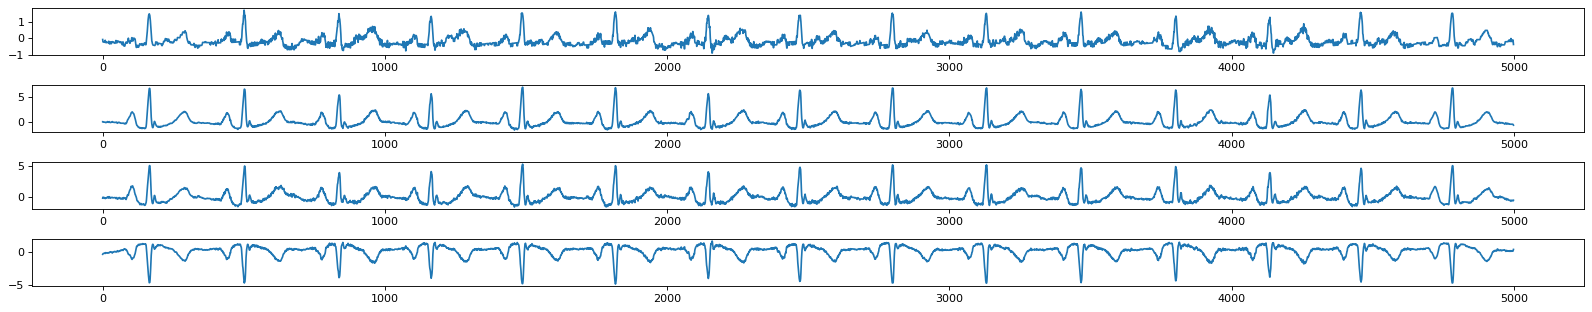

In [11]:
subject = 0

data = ecg[0][None, ...]

step = 1
plt.figure(figsize=(20, 4), dpi=80)

plt.subplot(4,1,1)
plt.plot(data[subject, 0, ::step])

plt.subplot(4,1,2)
plt.plot(data[subject, 1, ::step])

plt.subplot(4,1,3)
plt.plot(data[subject, 2, ::step])

plt.subplot(4,1,4)
plt.plot(data[subject, 3, ::step])

plt.tight_layout()
plt.show()

In [111]:
plt.rcParams.update({'font.size': 13})

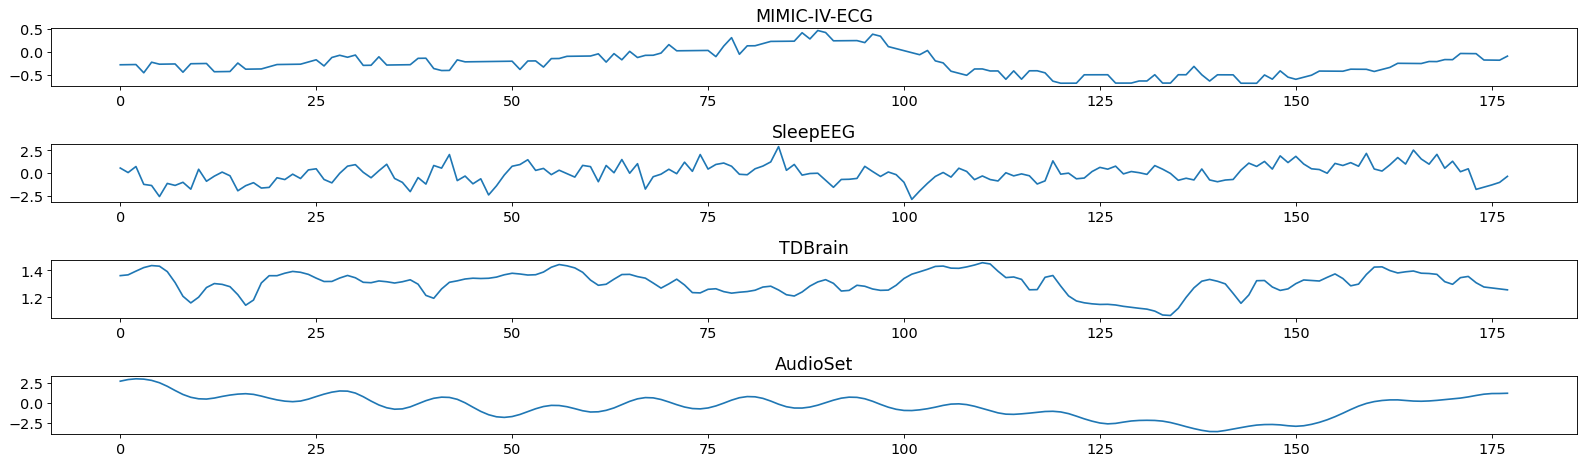

In [123]:
step = 1
plt.figure(figsize=(20, 6), dpi=80)

plt.subplot(4, 1, 1)
plt.plot(ecg[0, 0, 178*3:178*4:step])
plt.title("MIMIC-IV-ECG")

plt.subplot(4, 1, 2)
plt.plot(data_sleep[0][0, ::step])
plt.title("SleepEEG")

plt.subplot(4, 1, 3)
plt.plot(data_tdb[0][0, 178*30:178*31:step])
plt.title("TDBrain")

plt.subplot(4, 1, 4)
plt.plot(data_audio[0][10000:10178:step])
plt.title("AudioSet")

plt.tight_layout()
plt.show()

In [40]:
tst_data = torch.load("/home/oturgut/data/processed/signalnet/data_val_new.pt")

In [94]:
tst_data[0][1].shape

torch.Size([1, 19, 6000])